In [ ]:
%matplotlib inline

In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pandas as pd
import time
import numpy as np

from torch.utils.data import TensorDataset, RandomSampler, DataLoader

In [ ]:
df = pd.read_csv("/content/rus.txt", sep = "\t", header = None)
df

,0,1,2
0,Go.,Марш!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Иди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Идите.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Здравствуйте.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Привет!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
496054,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...
496055,"When I was younger, I hated going to weddings....","Когда я была помоложе, я ненавидела ходить на ...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
496056,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...
496057,If someone who doesn't know your background sa...,"Если кто-то незнакомый говорит, что вы говорит...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
df = df.drop(2, axis = 1)
df

,0,1
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
496054,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш..."
496055,"When I was younger, I hated going to weddings....","Когда я была помоложе, я ненавидела ходить на ..."
496056,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,..."
496057,If someone who doesn't know your background sa...,"Если кто-то незнакомый говорит, что вы говорит..."


In [ ]:
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [ ]:
df.columns = ["eng", "rus"]
df

,eng,rus
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
496054,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш..."
496055,"When I was younger, I hated going to weddings....","Когда я была помоложе, я ненавидела ходить на ..."
496056,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,..."
496057,If someone who doesn't know your background sa...,"Если кто-то незнакомый говорит, что вы говорит..."


In [ ]:
df["eng"] = df["eng"].apply(normalizeString)
df["rus"] = df["rus"].apply(normalizeString)
df

,eng,rus
0,go .,марш !
1,go .,иди .
2,go .,идите .
3,hi .,здравствуйте .
4,hi .,привет !
...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...


In [ ]:
vocab = {}

In [ ]:
SOS_token = 0
EOS_token = 1

In [ ]:
df["eng_list"] = df["eng"].str.split()
df["rus_list"] = df["rus"].str.split()
df

,eng,rus,eng_list,rus_list
0,go .,марш !,"[go, .]","[марш, !]"
1,go .,иди .,"[go, .]","[иди, .]"
2,go .,идите .,"[go, .]","[идите, .]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]"
4,hi .,привет !,"[hi, .]","[привет, !]"
...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ..."


In [ ]:
eng_series = df["eng_list"].apply(pd.Series).stack().reset_index(drop=True)
eng_series

,0
0,go
1,.
2,go
3,.
4,go
...,...
3706121,met
3706122,the
3706123,right
3706124,woman


In [ ]:
eng_set = set(eng_series)
len_eng = len(eng_set) + 2 # с добавлением 0 и 1
len_eng

17261

In [ ]:
rus_series = df["rus_list"].apply(pd.Series).stack().reset_index(drop=True)
rus_series

,0
0,марш
1,!
2,иди
3,.
4,идите
...,...
3111037,не
3111038,встретил
3111039,подходящую
3111040,женщину


In [ ]:
rus_series

,0
0,марш
1,!
2,иди
3,.
4,идите
...,...
3111037,не
3111038,встретил
3111039,подходящую
3111040,женщину


In [ ]:
rus_set = set(rus_series)
len_rus = len(rus_set) + 2 # с добавлением 0 и 1
len_rus

59746

In [ ]:
eng_vocab = {x: y for y, x in enumerate(eng_set, 2)}
eng_vocab

{'necklaces': 2,
 'unforgettable': 3,
 'teddy': 4,
 'polluted': 5,
 'tease': 6,
 'deficient': 7,
 'civilization': 8,
 'tarantula': 9,
 'arose': 10,
 'pharmacies': 11,
 'clothed': 12,
 'mansion': 13,
 'quitting': 14,
 'employees': 15,
 'stale': 16,
 'manners': 17,
 'ones': 18,
 'bribe': 19,
 'disrepair': 20,
 'birds': 21,
 'mismatched': 22,
 'bicycled': 23,
 'robotics': 24,
 'easygoing': 25,
 'unenthusiastically': 26,
 'mumble': 27,
 'localized': 28,
 'letters': 29,
 'jerusalem': 30,
 'productive': 31,
 'nudged': 32,
 'furnished': 33,
 'colors': 34,
 'uncooperative': 35,
 'packing': 36,
 'bounce': 37,
 'insulting': 38,
 'grandsons': 39,
 'architect': 40,
 'ancient': 41,
 'carousel': 42,
 'wraps': 43,
 'witches': 44,
 'skills': 45,
 'bachelors': 46,
 'beans': 47,
 'incorrigible': 48,
 'flashed': 49,
 'runny': 50,
 'valid': 51,
 'bulldozer': 52,
 'voices': 53,
 'judged': 54,
 'roasting': 55,
 'feature': 56,
 'clockwise': 57,
 'compiled': 58,
 'misunderstands': 59,
 'background': 60,
 'fra

In [ ]:
rus_vocab = {x: y for y, x in enumerate(rus_set, 2)}
rus_vocab

{'пообещаете': 2,
 'дохлый': 3,
 'интереса': 4,
 'товаров': 5,
 'раздавай': 6,
 'схватили': 7,
 'окончательным': 8,
 'аномалию': 9,
 'пропустил': 10,
 'вчерашнем': 11,
 'ухмыльнулся': 12,
 'тускловатым': 13,
 'подшофе': 14,
 'поприличнее': 15,
 'сотрудника': 16,
 'попрощаешься': 17,
 'вечерком': 18,
 'страховую': 19,
 'премию': 20,
 'исаак': 21,
 'презирает': 22,
 'безнадёжные': 23,
 'уклониться': 24,
 'окончен': 25,
 'устранить': 26,
 'взгляду': 27,
 'холостяки': 28,
 'перескочила': 29,
 'высочайшей': 30,
 'галстуков': 31,
 'потратила': 32,
 'опера': 33,
 'битой': 34,
 'сахарную': 35,
 'острые': 36,
 'сезонной': 37,
 'искусали': 38,
 'просыпайтесь': 39,
 'заявила': 40,
 'судьёй': 41,
 'фантаст': 42,
 'драконом': 43,
 'перегорожена': 44,
 'ушибла': 45,
 'едва': 46,
 'представила': 47,
 'доверяет': 48,
 'аутизма': 49,
 'следам': 50,
 'посетит': 51,
 'наблюдения': 52,
 'заметен': 53,
 'проработать': 54,
 'ванную': 55,
 'охвачен': 56,
 'ананас': 57,
 'жалуясь': 58,
 'овцевод': 59,
 'стона

In [ ]:
def encoding(s_list, vocab):
  list_words = []
  for word in s_list:
    list_words.append(vocab[word])
  return list_words

In [ ]:
encoding(["when", "i", "was", "younger", "i", "hated", "going", "shadow"], eng_vocab)

[5767, 12292, 13102, 1371, 12292, 605, 15379, 4902]

In [ ]:
encoding(["курс", "сумасбродствовать", "едете"], rus_vocab)

[2904, 8517, 459]

In [ ]:
df["encripted_eng"] = df["eng_list"].apply(lambda x: encoding(x, eng_vocab))
df

,eng,rus,eng_list,rus_list,encripted_eng
0,go .,марш !,"[go, .]","[марш, !]","[3224, 9824]"
1,go .,иди .,"[go, .]","[иди, .]","[3224, 9824]"
2,go .,идите .,"[go, .]","[идите, .]","[3224, 9824]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[13036, 9824]"
4,hi .,привет !,"[hi, .]","[привет, !]","[13036, 9824]"
...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[7713, 2060, 13398, 5767, 4632, 16652, 8211, 1..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[5767, 12292, 13102, 1371, 12292, 605, 15379, ..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[8475, 14107, 6509, 695, 2255, 13956, 3638, 94..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[11459, 9500, 7434, 14188, 12944, 7331, 8550, ..."


In [ ]:
df["encripted_rus"] = df["rus_list"].apply(lambda x: encoding(x, rus_vocab))
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus
0,go .,марш !,"[go, .]","[марш, !]","[3224, 9824]","[20680, 45167]"
1,go .,иди .,"[go, .]","[иди, .]","[3224, 9824]","[6552, 23334]"
2,go .,идите .,"[go, .]","[идите, .]","[3224, 9824]","[14455, 23334]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[13036, 9824]","[46882, 23334]"
4,hi .,привет !,"[hi, .]","[привет, !]","[13036, 9824]","[5734, 45167]"
...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[7713, 2060, 13398, 5767, 4632, 16652, 8211, 1...","[33955, 2316, 19774, 11437, 36926, 47250, 4257..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[5767, 12292, 13102, 1371, 12292, 605, 15379, ...","[11437, 54172, 48543, 36015, 54172, 34748, 216..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[8475, 14107, 6509, 695, 2255, 13956, 3638, 94...","[38528, 11910, 26312, 5468, 59253, 56063, 5280..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[11459, 9500, 7434, 14188, 12944, 7331, 8550, ...","[41991, 47665, 16009, 24138, 38691, 45006, 426..."


In [ ]:
df["encripted_eng"] = df["encripted_eng"].apply(lambda x: x + [EOS_token])
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus
0,go .,марш !,"[go, .]","[марш, !]","[3224, 9824, 1]","[20680, 45167]"
1,go .,иди .,"[go, .]","[иди, .]","[3224, 9824, 1]","[6552, 23334]"
2,go .,идите .,"[go, .]","[идите, .]","[3224, 9824, 1]","[14455, 23334]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[13036, 9824, 1]","[46882, 23334]"
4,hi .,привет !,"[hi, .]","[привет, !]","[13036, 9824, 1]","[5734, 45167]"
...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[7713, 2060, 13398, 5767, 4632, 16652, 8211, 1...","[33955, 2316, 19774, 11437, 36926, 47250, 4257..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[5767, 12292, 13102, 1371, 12292, 605, 15379, ...","[11437, 54172, 48543, 36015, 54172, 34748, 216..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[8475, 14107, 6509, 695, 2255, 13956, 3638, 94...","[38528, 11910, 26312, 5468, 59253, 56063, 5280..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[11459, 9500, 7434, 14188, 12944, 7331, 8550, ...","[41991, 47665, 16009, 24138, 38691, 45006, 426..."


In [ ]:
df["encripted_rus"] = df["encripted_rus"].apply(lambda x: x + [EOS_token])
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus
0,go .,марш !,"[go, .]","[марш, !]","[3224, 9824, 1]","[20680, 45167, 1]"
1,go .,иди .,"[go, .]","[иди, .]","[3224, 9824, 1]","[6552, 23334, 1]"
2,go .,идите .,"[go, .]","[идите, .]","[3224, 9824, 1]","[14455, 23334, 1]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[13036, 9824, 1]","[46882, 23334, 1]"
4,hi .,привет !,"[hi, .]","[привет, !]","[13036, 9824, 1]","[5734, 45167, 1]"
...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[7713, 2060, 13398, 5767, 4632, 16652, 8211, 1...","[33955, 2316, 19774, 11437, 36926, 47250, 4257..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[5767, 12292, 13102, 1371, 12292, 605, 15379, ...","[11437, 54172, 48543, 36015, 54172, 34748, 216..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[8475, 14107, 6509, 695, 2255, 13956, 3638, 94...","[38528, 11910, 26312, 5468, 59253, 56063, 5280..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[11459, 9500, 7434, 14188, 12944, 7331, 8550, ...","[41991, 47665, 16009, 24138, 38691, 45006, 426..."


In [ ]:
df["encripted_eng"].apply(len).max()

103

In [ ]:
df["encripted_rus"].apply(len).describe()

,encripted_rus
count,496059.000000
mean,7.271516
std,2.072407
min,3.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,84.000000


In [ ]:
df["encripted_rus"].apply(len).quantile(0.9)

10.0

In [ ]:
df["encripted_rus"].apply(len).max()

84

In [ ]:
df["encripted_eng"].apply(len).describe()

,encripted_eng
count,496059.000000
mean,8.471140
std,2.318955
min,3.000000
25%,7.000000
50%,8.000000
75%,10.000000
max,103.000000


In [ ]:
df["encripted_eng"].apply(len).quantile(0.9)

11.0

In [ ]:
df["encripted_eng_len"] = df["encripted_eng"].apply(len)
df["encripted_rus_len"] = df["encripted_rus"].apply(len)
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus,encripted_eng_len,encripted_rus_len
0,go .,марш !,"[go, .]","[марш, !]","[3224, 9824, 1]","[20680, 45167, 1]",3,3
1,go .,иди .,"[go, .]","[иди, .]","[3224, 9824, 1]","[6552, 23334, 1]",3,3
2,go .,идите .,"[go, .]","[идите, .]","[3224, 9824, 1]","[14455, 23334, 1]",3,3
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[13036, 9824, 1]","[46882, 23334, 1]",3,3
4,hi .,привет !,"[hi, .]","[привет, !]","[13036, 9824, 1]","[5734, 45167, 1]",3,3
...,...,...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[7713, 2060, 13398, 5767, 4632, 16652, 8211, 1...","[33955, 2316, 19774, 11437, 36926, 47250, 4257...",44,37
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[5767, 12292, 13102, 1371, 12292, 605, 15379, ...","[11437, 54172, 48543, 36015, 54172, 34748, 216...",50,48
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[8475, 14107, 6509, 695, 2255, 13956, 3638, 94...","[38528, 11910, 26312, 5468, 59253, 56063, 5280...",47,41
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[11459, 9500, 7434, 14188, 12944, 7331, 8550, ...","[41991, 47665, 16009, 24138, 38691, 45006, 426...",50,40


In [ ]:
df = df.query("encripted_eng_len < 12 and encripted_rus_len < 12").reset_index(drop = True)
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus,encripted_eng_len,encripted_rus_len
0,go .,марш !,"[go, .]","[марш, !]","[3224, 9824, 1]","[20680, 45167, 1]",3,3
1,go .,иди .,"[go, .]","[иди, .]","[3224, 9824, 1]","[6552, 23334, 1]",3,3
2,go .,идите .,"[go, .]","[идите, .]","[3224, 9824, 1]","[14455, 23334, 1]",3,3
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[13036, 9824, 1]","[46882, 23334, 1]",3,3
4,hi .,привет !,"[hi, .]","[привет, !]","[13036, 9824, 1]","[5734, 45167, 1]",3,3
...,...,...,...,...,...,...,...,...
446618,switzerland is situated between france italy a...,швейцария расположена между францией италией а...,"[switzerland, is, situated, between, france, i...","[швейцария, расположена, между, францией, итал...","[1195, 8211, 9303, 10704, 61, 12367, 4420, 138...","[2406, 18918, 878, 37785, 17536, 42148, 27245,...",11,10
446619,ethnic minorities struggle against prejudice p...,этнические меньшинства борются против предубеж...,"[ethnic, minorities, struggle, against, prejud...","[этнические, меньшинства, борются, против, пре...","[1843, 1713, 1462, 10249, 9723, 14587, 1385, 1...","[6813, 6934, 14511, 33666, 29045, 47558, 27245...",10,10
446620,civilization is the limitless multiplication o...,цивилизация это неограниченное умножение неопр...,"[civilization, is, the, limitless, multiplicat...","[цивилизация, это, неограниченное, умножение, ...","[8, 8211, 8599, 1845, 4275, 2124, 14332, 16115...","[560, 34049, 40781, 55082, 23713, 12307, 23334...",10,8
446621,subsequent constitutional reforms restored rel...,последующие конституционные реформы восстанови...,"[subsequent, constitutional, reforms, restored...","[последующие, конституционные, реформы, восста...","[2904, 1688, 4821, 7058, 869, 6271, 16670, 982...","[4654, 42413, 35039, 37699, 57587, 9694, 14573...",9,9


In [ ]:
n = len(df)
MAX_LENGTH = 11
batch_size = 32

input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

for idx in range(n):
    inp_ids = df.loc[idx, "encripted_eng"]
    tgt_ids = df.loc[idx, "encripted_rus"]
    input_ids[idx, :len(inp_ids)] = inp_ids
    target_ids[idx, :len(tgt_ids)] = tgt_ids

train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

In [ ]:
next(iter(train_dataloader))

[tensor([[10612,  6164,  8599, 10053, 12402, 12896,  5789,  9824,     1,     0,
              0],
         [12836,  1685,  3638,  8215,  9824,     1,     0,     0,     0,     0,
              0],
         [ 8599, 15924, 10573,  8599, 14599,  2674,  7331, 15427,  3892,  9824,
              1],
         [12292,  3127, 12944, 15041,  6891,  4809,   567,  4120,  7464,  9824,
              1],
         [ 8599,  1710,  7464,  6891,  5950, 16042,  9576, 12552,  9824,     1,
              0],
         [ 6891,  8211,  7952,  2060, 12082, 11690,  9824,     1,     0,     0,
              0],
         [ 9500,  1675,  6891, 15478,  7332,  9824,     1,     0,     0,     0,
              0],
         [ 8314, 16645,   825,  7464,  9824,     1,     0,     0,     0,     0,
              0],
         [ 7464, 15478, 13050,  9824,     1,     0,     0,     0,     0,     0,
              0],
         [12292, 10785, 10029,  2310,  3325,  6891,  9824,     1,     0,     0,
              0],
         [ 6891,  82

ЭНКОДЕР

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
#plt.switch_backend('notebook')
import matplotlib
%matplotlib inline
import matplotlib.ticker as ticker


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points);
    ax.set_xlabel("количество иттераций*1000")
    ax.set_ylabel("функция потерь")

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

8m 18s (- 33m 15s) (1 20%) 1.6925
16m 36s (- 24m 54s) (2 40%) 1.0391
24m 51s (- 16m 34s) (3 60%) 0.8762
33m 10s (- 8m 17s) (4 80%) 0.7861
41m 41s (- 0m 0s) (5 100%) 0.7259


<Figure size 640x480 with 0 Axes>

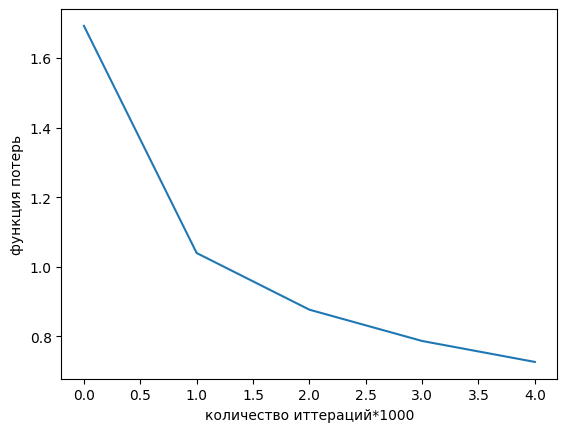

In [ ]:
hidden_size = 128

encoder = EncoderRNN(len_eng, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len_rus).to(device)

train(train_dataloader, encoder, decoder, 5, print_every = 1, plot_every = 1)

*в графике в подписи к иксам - количество эпох.

In [ ]:
def tensorFromSentence(sentence, vocab):
  list_words = []
  for word in sentence.split():
    list_words.append(vocab[word])
  list_words.append(EOS_token)
  return torch.tensor(list_words, dtype=torch.long, device=device).view(1, -1)

In [ ]:
vocab_reverse_ru = {x: y for y, x in rus_vocab.items()}
vocab_reverse_ru

{2: 'пообещаете',
 3: 'дохлый',
 4: 'интереса',
 5: 'товаров',
 6: 'раздавай',
 7: 'схватили',
 8: 'окончательным',
 9: 'аномалию',
 10: 'пропустил',
 11: 'вчерашнем',
 12: 'ухмыльнулся',
 13: 'тускловатым',
 14: 'подшофе',
 15: 'поприличнее',
 16: 'сотрудника',
 17: 'попрощаешься',
 18: 'вечерком',
 19: 'страховую',
 20: 'премию',
 21: 'исаак',
 22: 'презирает',
 23: 'безнадёжные',
 24: 'уклониться',
 25: 'окончен',
 26: 'устранить',
 27: 'взгляду',
 28: 'холостяки',
 29: 'перескочила',
 30: 'высочайшей',
 31: 'галстуков',
 32: 'потратила',
 33: 'опера',
 34: 'битой',
 35: 'сахарную',
 36: 'острые',
 37: 'сезонной',
 38: 'искусали',
 39: 'просыпайтесь',
 40: 'заявила',
 41: 'судьёй',
 42: 'фантаст',
 43: 'драконом',
 44: 'перегорожена',
 45: 'ушибла',
 46: 'едва',
 47: 'представила',
 48: 'доверяет',
 49: 'аутизма',
 50: 'следам',
 51: 'посетит',
 52: 'наблюдения',
 53: 'заметен',
 54: 'проработать',
 55: 'ванную',
 56: 'охвачен',
 57: 'ананас',
 58: 'жалуясь',
 59: 'овцевод',
 60: 'с

In [ ]:
def evaluate(encoder, decoder, sentence, vocab, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence, vocab)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(vocab_reverse_ru[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
evaluate(encoder, decoder, "you are very crazy dog", eng_vocab)

(['ты', 'очень', 'доволен', 'собаку', 'с', 'собакой', '.', '<EOS>'],
 tensor([[[4.5137e-01, 1.0930e-01, 1.4006e-01, 1.7100e-01, 1.1319e-01,
           1.5078e-02],
          [6.4816e-02, 3.4120e-02, 3.5585e-01, 4.0049e-01, 1.3037e-01,
           1.4354e-02],
          [7.2514e-03, 8.1249e-03, 1.2399e-01, 5.0423e-01, 3.4012e-01,
           1.6277e-02],
          [5.5617e-03, 2.5044e-03, 9.8253e-03, 4.1369e-01, 5.5667e-01,
           1.1752e-02],
          [1.8454e-05, 9.4242e-05, 2.4426e-02, 3.7893e-01, 5.4274e-01,
           5.3790e-02],
          [3.0458e-07, 1.8020e-05, 1.8946e-03, 3.1365e-02, 7.7114e-01,
           1.9559e-01],
          [1.4316e-06, 1.2066e-05, 9.8994e-03, 3.3528e-01, 4.4646e-01,
           2.0834e-01],
          [5.3648e-07, 7.0530e-06, 7.2941e-04, 3.9048e-02, 6.5181e-01,
           3.0840e-01],
          [9.9488e-08, 2.2950e-06, 2.1358e-04, 3.2834e-02, 3.3234e-01,
           6.3461e-01],
          [2.5810e-08, 9.1268e-07, 1.9882e-04, 7.3157e-02, 2.8722e-01,
     

In [ ]:
def evaluateRandomly(encoder, decoder, l=10):
    for i in range(l):
        index = random.randint(0, n)
        print('>', df.loc[index, "eng"])
        print('=', df.loc[index, "rus"])
        output_words, _ = evaluate(encoder, decoder, df.loc[index, "eng"], eng_vocab)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> why is your method better ?
= почему ваш метод лучше ?
< почему ваш метод лучше ? <EOS>

> who wants to go shopping with me ?
= кто хочет со мной по магазинам ?
< кто хочет пойти со мной за покупками ? <EOS>

> thank you for helping me with my homework .
= спасибо что помог мне с уроками .
< спасибо что помогли мне с уроками . <EOS>

> you always made my decisions for me .
= ты всегда принимал за меня решения .
< ты всегда заставил меня к себе моих решения . <EOS>

> i took a day off .
= я взял отгул .
< я снял день за день . <EOS>

> i want to play tennis with you someday .
= когда нибудь я хочу сыграть с тобой в теннис .
< я хочу сыграть с вами в теннис . <EOS>

> the socialist party only got of the votes .
= социалистическая партия получила только голосов .
< у тома единственный телефон остался . <EOS>

> you re famous .
= ты знаменит .
< вы знамениты . <EOS>

> tom will recover .
= том поправится .
< том поправится . <EOS>

> are you afraid of a little girl ?
= вы боитесь маленьк

Получилось лучше по сравнению с только с GRU-ячейкой в предыдущей домашней работе.

ДЕКОДЕР ДЛЯ MLP ATTENTION

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiheadAttention, self).__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        assert (
            self.head_dim * num_heads == hidden_size
        ), "Hidden size must be divisible by number of heads"

        self.Wq = nn.Linear(hidden_size, hidden_size)
        self.Wk = nn.Linear(hidden_size, hidden_size)
        self.Wv = nn.Linear(hidden_size, hidden_size)

        self.fc_out = nn.Linear(hidden_size, hidden_size)

    def forward(self, query, keys, values, mask=None):
        batch_size = query.size(0)
        seq_length = keys.size(1)  # number of keys (and values)

        # Linear projections
        Q = self.Wq(query)  # shape (batch_size, query_length, hidden_size)
        K = self.Wk(keys)    # shape (batch_size, seq_length, hidden_size)
        V = self.Wv(values)  # shape (batch_size, seq_length, hidden_size)

        # Reshape to (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, query_length, head_dim)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_length, head_dim)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_length, head_dim)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # shape (batch_size, num_heads, query_length, seq_length)

        if mask is not None:
            scores += mask  # Apply mask

        weights = F.softmax(scores, dim=-1)  # shape (batch_size, num_heads, query_length, seq_length)

        # Compute context vector
        context = torch.matmul(weights, V)  # shape (batch_size, num_heads, query_length, head_dim)

        # Reshape back to (batch_size, query_length, hidden_size)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)  # (batch_size, query_length, hidden_size)

        # Final linear transformation
        output = self.fc_out(context)  # shape (batch_size, query_length, hidden_size)

        return output, weights



class MLPAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_head = 2, dropout_p=0.1):
        super(MLPAttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MultiheadAttention(hidden_size, n_head)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

8m 59s (- 35m 57s) (1 20%) 1.7663
18m 8s (- 27m 13s) (2 40%) 1.1173
27m 5s (- 18m 3s) (3 60%) 0.9455
36m 1s (- 9m 0s) (4 80%) 0.8502
45m 20s (- 0m 0s) (5 100%) 0.7863


<Figure size 640x480 with 0 Axes>

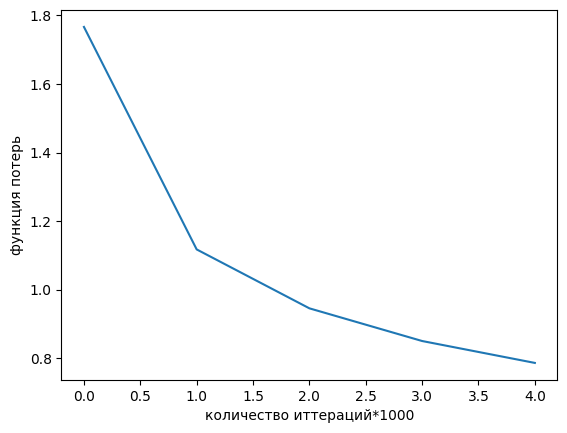

In [ ]:
hidden_size = 128

encoder = EncoderRNN(len_eng, hidden_size).to(device)
decoder = MLPAttnDecoderRNN(hidden_size, len_rus).to(device)

train(train_dataloader, encoder, decoder, 5, print_every = 1, plot_every = 1)

In [ ]:
evaluate(encoder, decoder, "you are very crazy dog", eng_vocab)

(['ты', 'очень', 'собаку', 'с', 'собакой', '?', '<EOS>'],
 tensor([[[[6.4319e-02, 4.0082e-01, 3.7240e-01, 9.1081e-02, 5.9473e-02,
            1.1908e-02]],
 
          [[8.3258e-01, 6.1541e-02, 7.3451e-02, 2.7331e-02, 4.5149e-03,
            5.8020e-04]],
 
          [[1.8960e-02, 2.0923e-02, 2.2850e-01, 4.2630e-01, 2.7717e-01,
            2.8143e-02]],
 
          [[1.1722e-02, 2.8286e-02, 8.8578e-01, 7.2844e-02, 1.2468e-03,
            1.1702e-04]],
 
          [[3.0028e-02, 3.6567e-02, 1.6403e-01, 5.0624e-01, 2.3999e-01,
            2.3144e-02]],
 
          [[1.0474e-02, 9.8915e-04, 3.1469e-02, 8.6754e-01, 8.9155e-02,
            3.7305e-04]],
 
          [[5.7595e-02, 1.1272e-01, 1.4965e-01, 3.0850e-01, 3.2332e-01,
            4.8223e-02]],
 
          [[4.5613e-02, 3.2421e-03, 3.2644e-02, 2.2332e-01, 6.8994e-01,
            5.2382e-03]],
 
          [[1.2517e-01, 7.5801e-02, 8.3361e-02, 1.7563e-01, 2.8520e-01,
            2.5484e-01]],
 
          [[3.7356e-03, 1.5176e-03, 3.4366

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> tom told me he wasn t worried .
= том сказал мне что он не беспокоится .
< том сказал мне что он не беспокоится . <EOS>

> i can t remember what tom looks like .
= я не могу вспомнить как выглядит том .
< я не могу вспомнить что том выглядит как том . <EOS>

> do you like that shirt ?
= тебе нравится та рубашка ?
< тебе нравится эта рубашка ? <EOS>

> did tom brush his teeth ?
= том почистил зубы ?
< том почистил зубы ? <EOS>

> he kept calm in the face of the danger .
= он сохранял спокойствие перед лицом опасности .
< он продолжал смотреть в лицо . <EOS>

> i go anywhere i want .
= я хожу куда хочу .
< я куда то же хочу пойти . <EOS>

> i must buy one of these .
= я должен одну купить .
< я должен купить одно одно из этих . <EOS>

> let me call tom .
= давай я позвоню тому .
< позвольте мне позвонить тому . <EOS>

> tom didn t even know who i was .
= том даже не знал кто я .
< том даже не знал кто я . <EOS>

> we have to wait .
= нам надо подождать .
< нам надо подождать подождать 

Для улучшения качества перевода можно попробовать увеличить количество голов и размерность скрытого состояния. Или взять более прогрессивную архитектуру - трансформер.